In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares

# Modeling Biacore experiments of Cre/LiCre binding to loxP sites

## 1) Binding to half loxP sites

The mathematical model that characterize the binding of Cre/Licre ($C$) to an empty half Lox P site ($P_0$):
\begin{eqnarray}
d[C]/dt & = & k_t ([C]_0-[C])-k_1 [C][P_0]+k_{-1} [P_1]\\
d[P_0]/dt & = & - k_1 [C][P_0]+k_{-1} [P_1] \\
d[P_1]/dt & = &   k_1 [C][P_0]-k_{-1} [P_1]
\end{eqnarray}
with: ***xxxdaniel: validate my defs***
- $[C]$ the concentration of free (unbound) Cre/LiCre protein in the chamber
- $[P_0]$ the concentration of immobilized target DNA that is unoccupied
- $[P_1]$ the concentration of immobilized target DNA that is occupied by one Cre/LiCre protein
- $[C]_0 >0$ in the association phase and $[C]_0=0$ in the dissociation phase: the concentration of the protein in the injected solution.
- $[P_{tot}] = [P_0] + [P_1]$ the total concentration of immobilized target DNA

Here immobilized target DNA are half loxP sites.

We consider here that the Biacore signal directly reflects that concentration of bound proteins: $B(t)=[P_1]$.


In [2]:
# differential equation of the half loxP system
def half(y,t,param):
    C0,ta,Ptot,kt,k1,km1=param
    dy=[0,0] #(dC/dt,dP_1/dt)
    P0=Ptot-y[1]
    if t<ta:
        dy[0]=kt*(C0-y[0])-k1*y[0]*P0+km1*y[1]
        dy[1]=k1*y[0]*P0-km1*y[1]
    else:
        dy[0]=kt*(-y[0])-k1*y[0]*P0+km1*y[1]
        dy[1]=k1*y[0]*P0-km1*y[1]
    return dy



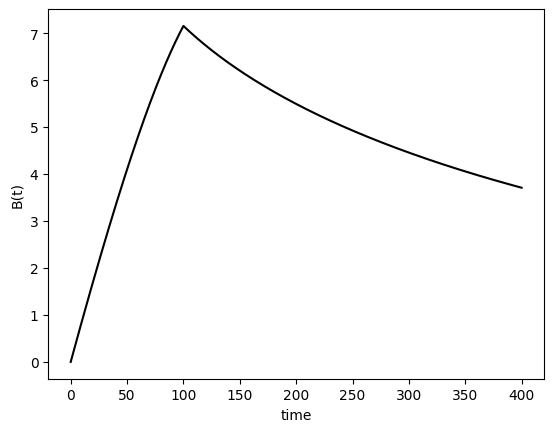

In [3]:
# example
param=[2.5e-9, 100, 10,4e7,3e7,0.01] #C0,ta,Ptot,kt,k1,km1=param
ti =np.linspace(0,400,10000)
y0=[0,0]
ys=odeint(half,y0,ti,args=(param,))
plt.plot(ti,ys[:,1],'k')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

## 2) Binding to full loxP sites
### 2.1) standard model with only monomeric form of ligand
The mathematical model that characterize the binding of Cre/Licre ($C$) to a full Lox P site ($P_0$):
\begin{eqnarray}
d[C]/dt & = & k_t ([C]_0-[C])-2 k_1 [C][P_0]+k_{-1} [P_1]-k_2 [C] [P_1]+2 k_{-2} [P_2]\\
d[P_0]/dt & = & - 2 k_1 [C][P_0]+k_{-1} [P_1] \\
d[P_1]/dt & = &   2 k_1 [C][P_0]-k_{-1} [P_1]-k_2 [C] [P_1]+2 k_{-2} [P_2]\\
d[P_2]/dt & = & k_2 [C] [P_1]-2 k_{-2} [P_2]
\end{eqnarray}

With the same definitions as above and with:
- $[P_2]$ the concentration of immobilized target DNA that is occupied by two Cre/LiCre proteins
- $[P_{tot}] = [P_0] + [P_1] + [P_2]$ the total concentration of immobilized target DNA

We consider here that the Biacore signal directly reflects that concentration of bound proteins: $B(t)=[P_1]+2[P_2]$.


In [4]:
# differential equation of the loxP system 1
def full1(y,t,param):
    C0,ta,Ptot,kt,k1,km1,k2,km2=param
    dy=[0,0,0] #dC/dt,dP_1/dt,dP_2/dt
    P0=Ptot-y[1]-y[2]
    if t<ta:
        dy[0]=kt*(C0-y[0])-2*k1*y[0]*P0+km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]
        dy[1]= 2*k1*y[0]*P0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    else:
        dy[0]=kt*(-y[0])-2*k1*y[0]*P0+km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]
        dy[1]= 2*k1*y[0]*P0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    return dy


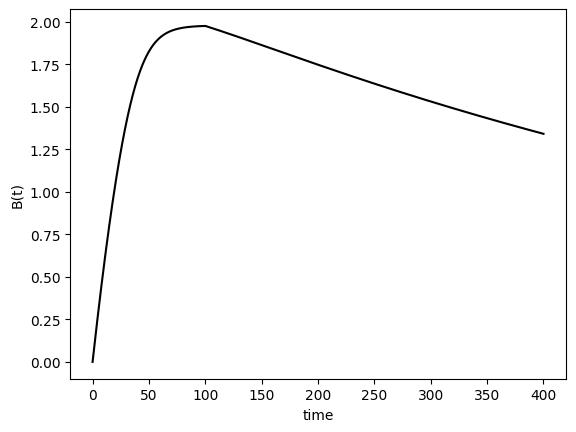

In [5]:
# example
param=[2.5e-9, 100, 1,4e7,3e7,0.01,4e7,0.001] #C0,ta,Ptot,kt,k1,km1,k2,km2=param

ti =np.linspace(0,400,10000)
y0=[0,0,0]
ys=odeint(full1,y0,ti,args=(param,))
plt.plot(ti,ys[:,1]+2*ys[:,2],'k')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

### 2.2) model with possible detachment of the ligand as a dimer
The mathematical model that characterize the binding of Cre/Licre ($C$) to a full Lox P site ($P_0$):
\begin{eqnarray}
d[C]/dt & = & k_t ([C]_0-[C])-2 k_1 [C][P_0]+k_{-1} [P_1]-k_2 [C] [P_1]+2 k_{-2} [P_2]+2 k_{diss}[C_{dim}]\\
d[C_{dim}] & = & -k_{t}[C_{dim}]+ k_{dim} [P_2]-k_{diss}[C_{dim}]\\
d[P_0]/dt & = & - 2 k_1 [C][P_0]+k_{-1} [P_1] + k_{dim} [P_2] \\
d[P_1]/dt & = &   2 k_1 [C][P_0]-k_{-1} [P_1]-k_2 [C] [P_1]+2 k_{-2} [P_2]\\
d[P_2]/dt & = & k_2 [C] [P_1]-2 k_{-2} [P_2]-k_{dim} [P_2]
\end{eqnarray}

With the same definitions as above and with: ***xxxDaniel: validate my defs***
- $[C_{dim}]$ the concentration of dimers of Cre/LiCre proteins in the chamber
- $[k_{dim}]$ the rate of dissociation of one dimer from its bound DNA
- $[k_{diss}]$ the rate of dissociation of the dimer into two protein monomers

Again, we consider here that the Biacore signal directly reflects that concentration of bound proteins: $B(t)=[P_1]+2[P_2]$.

We assume here that the transport coefficient $k_t$ is the same for monomers and for dimers

In [6]:
# differential equation of the loxP system 2
def full2(y,t,param):
    C0,ta,Ptot,kt,k1,km1,k2,km2,kdim,kdiss=param
    dy=[0,0,0,0] #dC/dt,dCdim/dt,dP_1/dt,dP_2/dt
    P0=Ptot-y[2]-y[3]
    if t<ta:
        dy[0]=kt*(C0-y[0])-2*k1*y[0]*P0+km1*y[2]-k2*y[0]*y[2]+2*km2*y[3]+2*kdiss*y[1]
        dy[1]=-kt*y[1]+kdim*y[3]-kdiss*y[1]
        dy[2]= 2*k1*y[0]*P0-km1*y[2]-k2*y[0]*y[2]+2*km2*y[3]  
        dy[3]= k2*y[0]*y[2]-2*km2*y[3]-kdim*y[3] 
    else:
        dy[0]=kt*(-y[0])-2*k1*y[0]*P0+km1*y[2]-k2*y[0]*y[2]+2*km2*y[3]+2*kdiss*y[1]
        dy[1]=-kt*y[1]+kdim*y[3]-kdiss*y[1]
        dy[2]= 2*k1*y[0]*P0-km1*y[2]-k2*y[0]*y[2]+2*km2*y[3]  
        dy[3]= k2*y[0]*y[2]-2*km2*y[3]-kdim*y[3] 
    return dy


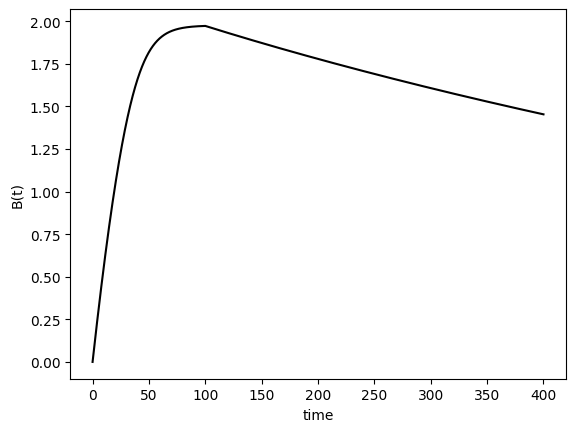

In [7]:
# example
param=[2.5e-9, 100, 1,4e7,3e7,0.01,4e7,0.0,0.001,1] #C0,ta,Ptot,kt,k1,km1,k2,km2,kdim,kdiss=param

ti =np.linspace(0,400,10000)
y0=[0,0,0,0]
ys=odeint(full2,y0,ti,args=(param,))
plt.plot(ti,ys[:,2]+2*ys[:,3],'k')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

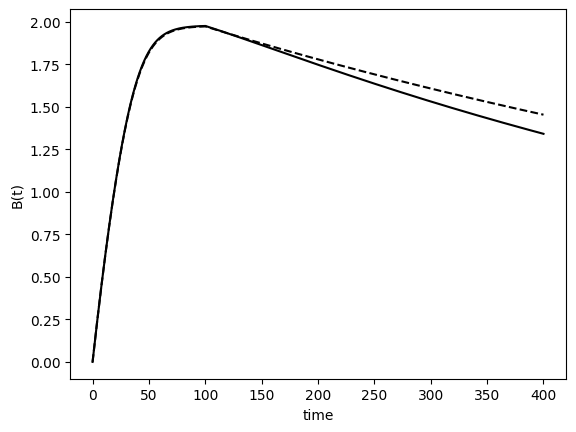

In [8]:
# comparison between both models
#C0,ta,Ptot,kt,k1,km1,k2,km2(,kdim,kdiss)=param
ti =np.linspace(0,400,10000)

#model 1
param=[2.5e-9, 100, 1,4e7,3e7,0.01,4e7,0.001]
y0=[0,0,0]
ys=odeint(full1,y0,ti,args=(param,))
plt.plot(ti,ys[:,1]+2*ys[:,2],'k')
#model 2
param=[2.5e-9, 100, 1,4e7,3e7,0.01,4e7,0.0,0.001,0.1]
y0=[0,0,0,0]
ys=odeint(full2,y0,ti,args=(param,))
plt.plot(ti,ys[:,2]+2*ys[:,3],'--k')

axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

We see that dissociation from DNA is slower when including possible detachment as a dimer (dashed line)

# Fitting model parameters to experimental Biacore data
## 1) Fitting using model and data for half-loxP site only

The Biacore signal (Response Units) $B(t)$ does not directly reflects the amount of bound proteins but is proportional to it: $B(t)=\alpha P_1$. If we note $B_0=\alpha P_0$ and $RU_{max}=\alpha P_{tot}$, then
\begin{eqnarray}
d[C]/dt & = & k_t ([C]_0-[C])-(k_1/\alpha) [C](RU_{max}-B)+(k_{-1}/\alpha) B\\
dB/dt & = &   k_1 [C](RU_{max}-B)-k_{-1} B
\end{eqnarray}
Rule of thumb derived from Rufer et al: $RU_{max}\approx 0.033 RU_{DNA}m_{binder}n_{site}$ with $m_{binder}$ the molar mass of the binder in kDa (38 for Cre, 55 for LiCre) and $n_{site}$ the number of binding site (1 for half-lox, 2 for lox). And $\alpha\approx 0.04 m_{binder}$.


In [9]:
def halfb(y,t,param): #y=(C,B)
    alp,C0,ta,RUmax,kt,k1,km1=param
    dy=[0,0] #(dC/dt,dB/dt)
    B0=RUmax-y[1]
    if t<ta:
        dy[0]=kt*(C0-y[0])-k1/alp*y[0]*B0+km1/alp*y[1]
        dy[1]=k1*y[0]*B0-km1*y[1]
    else:
        dy[0]=kt*(-y[0])-k1/alp*y[0]*B0+km1/alp*y[1]
        dy[1]=k1*y[0]*B0-km1*y[1]
    return dy


In [10]:
#test on simulated data
Nconc=2 #number of different concentrations
Lconc=[2.5,5] #list of concentrations in nM
ta=100 #duration of the association phase in sec
Ntime=50 #number of time points to fit
Ltime=np.linspace(0,400,Ntime) #list of time points in sec.
alp=10 #factor to pass from P1 to B in RU/nM unit
RUmax=100 #in RU unit
kt=0.5 #in 1/sec
k1=1 #in 1/(nM.sec)
km1=1 #in 1/sec
Data=np.zeros((Ntime,Nconc))
Data[:,0]=odeint(halfb,[0,0],Ltime,args=([alp,2.5, ta, RUmax,kt,k1,km1],))[:,1] # Ntime x Nconc matrix with the data (one row per concentration)
Data[:,1]=odeint(halfb,[0,0],Ltime,args=([alp,5, ta, RUmax,kt,k1,km1],))[:,1] # Ntime x Nconc matrix with the data (one row per concentration)


def fithalf(param,xdata,ydata):
    Nconc,Lconc,Ntime,Ltime,ta=xdata
    alp,RUmax,kt,k1,km1=param
    y=np.zeros((Ntime,Nconc))
    for c in range(Nconc):
        y[:,c]=odeint(halfb,[0,0],Ltime,args=([alp,Lconc[c],ta,RUmax,kt,k1,km1],))[:,1]
    return (y-ydata).flatten()

param0=[50,10,1,2,0.5]
pfit=least_squares(fithalf,param0,jac='3-point',method='trf',args=([Nconc,Lconc,Ntime,Ltime,ta],Data))
print("scoring function:",pfit.cost)
print("parameters (alp,RUmax,kt,k1,km1):",pfit.x)

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


scoring function: 27.683622244374323
parameters (alp,RUmax,kt,k1,km1): [2.39714466e+01 9.98038041e+01 5.24651600e+01 6.17240967e-02
 6.17221003e-02]


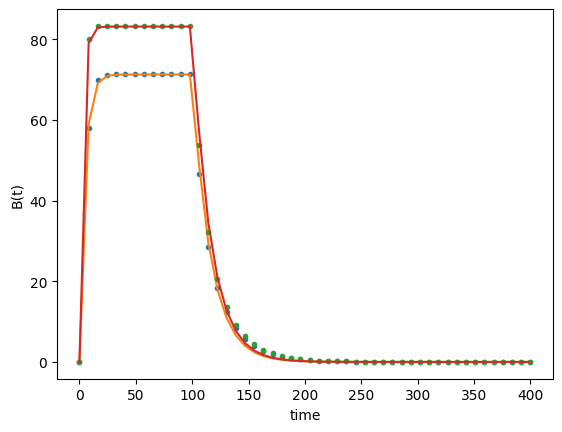

In [11]:
solu=(pfit.fun).reshape(Ntime,Nconc)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

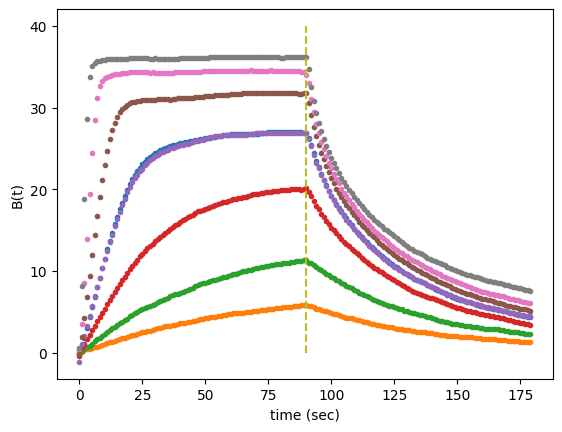

In [12]:
#load biacore data for Cre and extract data
# RU_DNA=32 RU so RU_max ~ 40 and alp~1.5
dts=np.loadtxt('../../data/2023-06-01/biacore_cre_half_loxP.txt')
Nconc=len(np.unique(dts[:,1]))
Lconc=np.zeros(Nconc)
for c in range(1,Nconc+1):
    a=np.argwhere(dts[:,1]==c)
    Lconc[c-1]=dts[a[1],0] #in nM 
Ltime=dts[a,2]
ta=90 #in sec
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=2401 #index to end the fit
idt=10 #index of the step between two fitted points
Ltime=Ltime[np.arange(itimemin,itimemax,idt)]
Ntime=len(Ltime)

Data=np.zeros((Ntime,Nconc))
for c in range(Nconc):
    a=np.argwhere(dts[:,1]==(c+1))
    Data[:,c]=dts[a[np.arange(itimemin,itimemax,idt)],3].ravel()
    
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
plt.plot(ta+np.zeros(10),np.linspace(0,40,10),'--')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 2.3538078676142584
parameters (alp,RUmax,kt,k1,km1): [ 0.86304374 38.51327356  0.57624222  3.2210997   3.67870942]


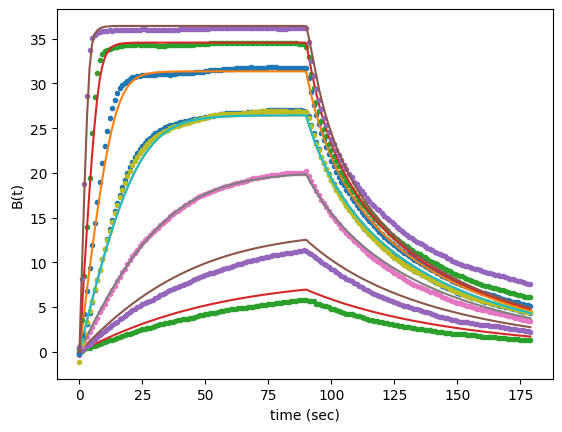

In [13]:
#infer based on absolute
param0=[1.5,40,1,0.1,0.1]
pfit=least_squares(fithalf,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1):",pfit.x)

solu=(pfit.fun).reshape(Ntime,Nconc)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 0.005561942314965471
parameters (alp,RUmax,kt,k1,km1): [ 1.13969089 39.32006959  0.42904853  0.63110545  0.7982626 ]


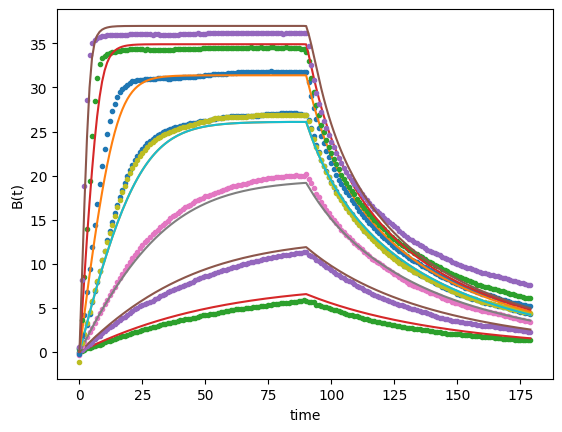

In [14]:
#infer based on relative
def fithalfrel(param,xdata,ydata):
    Nconc,Lconc,Ntime,Ltime,ta,eps=xdata
    alp,RUmax,kt,k1,km1=param
    y=np.zeros((Ntime,Nconc))
    for c in range(Nconc):
        y[:,c]=odeint(halfb,[0,0],Ltime,args=([alp,Lconc[c],ta,RUmax,kt,k1,km1],))[:,1]
    return ((y-ydata)/(ydata+eps)).flatten()


eps=10.
param0=[1.5,40,0.5,0.02,0.1]
pfit=least_squares(fithalfrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta,eps],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1):",pfit.x)

solu=((pfit.fun).reshape(Ntime,Nconc))*(Data+eps)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

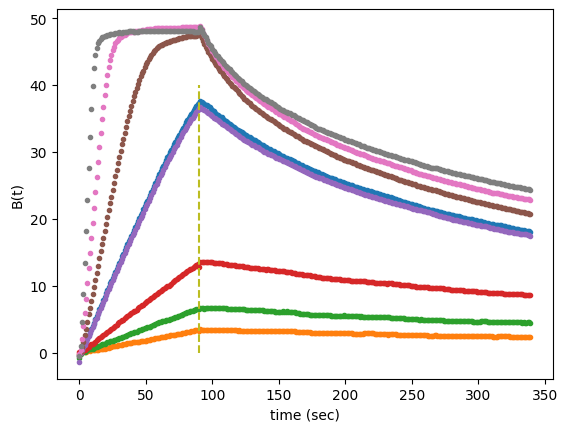

In [15]:
#load biacore data for LiCre and extract data
# RU_DNA=32 RU so RU_max ~ 50 and alp~2
dts=np.loadtxt('../../data/2023-06-01/biacore_licre_half_loxP.txt')
Nconc=len(np.unique(dts[:,1]))
Lconc=np.zeros(Nconc)
for c in range(1,Nconc+1):
    a=np.argwhere(dts[:,1]==c)
    Lconc[c-1]=dts[a[1],0] #in nM 
Ltime=dts[a,2]
ta=90 #in sec
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=4001 #index to end the fit
idt=10 #index of the step between two fitted points
Ltime=Ltime[np.arange(itimemin,itimemax,idt)]
Ntime=len(Ltime)

Data=np.zeros((Ntime,Nconc))
for c in range(Nconc):
    a=np.argwhere(dts[:,1]==(c+1))
    Data[:,c]=dts[a[np.arange(itimemin,itimemax,idt)],3].ravel()
    
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
plt.plot(ta+np.zeros(10),np.linspace(0,40,10),'--')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 14.187112195670103
parameters (alp,RUmax,kt,k1,km1): [ 1.32739835 50.62560935  0.13205445  3.70224877  1.36982758]


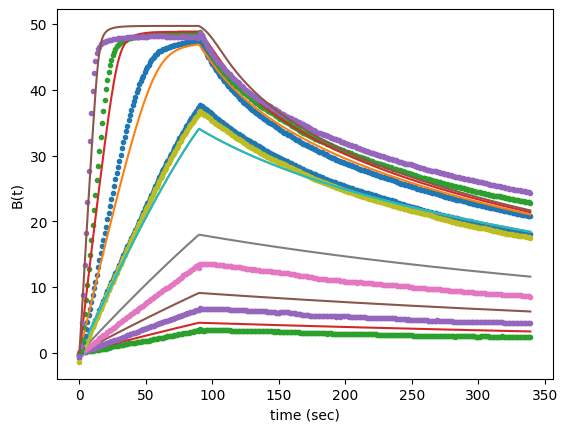

In [16]:
#infer based on absolute
param0=[1.5,50,0.5,0.1,0.1]
pfit=least_squares(fithalf,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1):",pfit.x)

solu=(pfit.fun).reshape(Ntime,Nconc)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 0.01941972591400565
parameters (alp,RUmax,kt,k1,km1): [ 0.63104483 52.99547807  0.24362194  1.21594912  0.54794171]


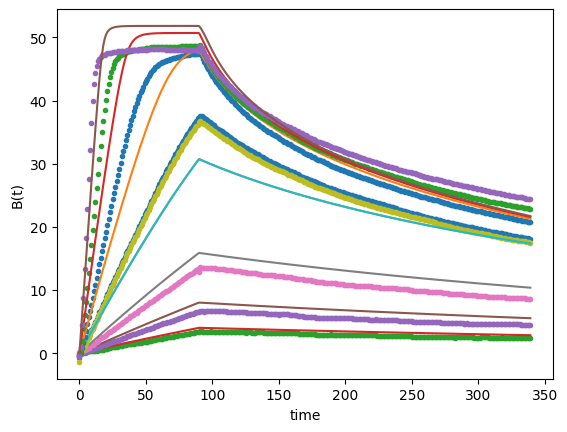

In [17]:
#infer on relative
eps=10.
param0=[1.5,50,0.5,0.1,0.1]
pfit=least_squares(fithalfrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta,eps],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1):",pfit.x)

solu=((pfit.fun).reshape(Ntime,Nconc))*(Data+eps)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

## 2) Fitting using model and data for full loxP site only

The biacore signal $B(t)$ (RU unit) is equal to $B(t)=\alpha (P_1+2 P_2)$. If we note $B_{0/1/2}=\alpha P_{0/1/2}$ and $RU_{max}=2\alpha P_{tot}$, $B=B_1+2B_2$.
The mathematical model that characterize the binding of Cre/Licre ($C$) to a full Lox P site:
\begin{eqnarray}
d[C]/dt & = & k_t ([C]_0-[C])-2 (k_1/\alpha) [C](RU_{max}/2-B_1-B_2)+(k_{-1}/\alpha) B_1-(k_2/\alpha) [C] B_1 +2 (k_{-2}/\alpha) B_2\\
dB_1/dt & = &   2 k_1 [C](RU_{max}/2-B_1-B_2)-k_{-1} B_1-k_2 [C] B_1+2 k_{-2} B_2\\
dB_2/dt & = & k_2 [C] B_1-2 k_{-2} B_2
\end{eqnarray}

In [18]:
# differential equation of the loxP system 1
def full1b(y,t,param): #y=(C,B1,B2)
    alp,C0,ta,RUmax,kt,k1,km1,k2,km2=param
    dy=[0,0,0] #dC/dt,dB_1/dt,dB_2/dt
    B0=RUmax/2-y[1]-y[2]
    if t<ta:
        dy[0]=kt*(C0-y[0])-2*(k1/alp)*y[0]*B0+(km1/alp)*y[1]-(k2/alp)*y[0]*y[1]+2*(km2/alp)*y[2]
        dy[1]= 2*k1*y[0]*B0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    else:
        dy[0]=kt*(-y[0])-2*k1/alp*y[0]*B0+km1/alp*y[1]-k2/alp*y[0]*y[1]+2*km2/alp*y[2]
        dy[1]= 2*k1*y[0]*B0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    return dy

In [19]:
#infer based on relative
def fitfullrel(param,xdata,ydata):
    Nconc,Lconc,Ntime,Ltime,ta,eps=xdata
    alp,RUmax,kt,k1,km1,k2,km2=param
    y=np.zeros((Ntime,Nconc))
    for c in range(Nconc):
        s=odeint(full1b,[0,0,0],Ltime,args=([alp,Lconc[c],ta,RUmax,kt,k1,km1,k2,km2],))
        y[:,c]=s[:,1]+2*s[:,2]
    return ((y-ydata)/(ydata+eps)).flatten()

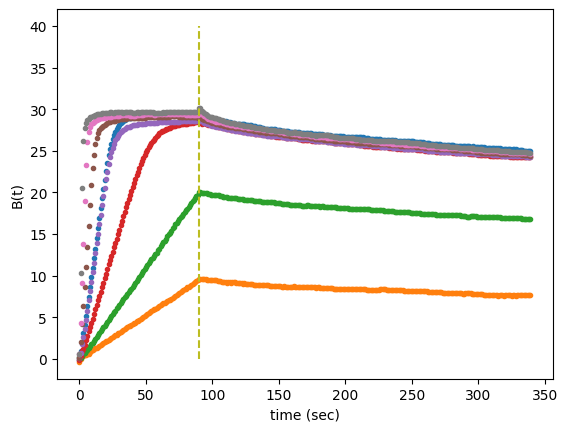

In [20]:
#load biacore data for Cre and extract data
# RU_DNA=11 RU so RU_max ~ 27 and alp~1.5
dts=np.loadtxt('../../data/2023-06-01/biacore_cre_full_loxP.txt')
Nconc=len(np.unique(dts[:,1]))
Lconc=np.zeros(Nconc)
for c in range(1,Nconc+1):
    a=np.argwhere(dts[:,1]==c)
    Lconc[c-1]=dts[a[1],0] #in nM 
Ltime=dts[a,2]
ta=90 #in sec
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=4001 #index to end the fit
idt=10 #index of the step between two fitted points
Ltime=Ltime[np.arange(itimemin,itimemax,idt)]
Ntime=len(Ltime)
               
Data=np.zeros((Ntime,Nconc))
for c in range(Nconc):
    a=np.argwhere(dts[:,1]==(c+1))
    Data[:,c]=dts[a[np.arange(itimemin,itimemax,idt)],3].ravel()
    
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
plt.plot(ta+np.zeros(10),np.linspace(0,40,10),'--')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 0.0007033646988368777
parameters (alp,RUmax,kt,k1,km1,k2,km2): [6.85479839e-01 2.86889442e+01 8.05670502e-01 3.05418012e-01
 1.30047413e+01 6.00095379e+00 3.71639367e-04]


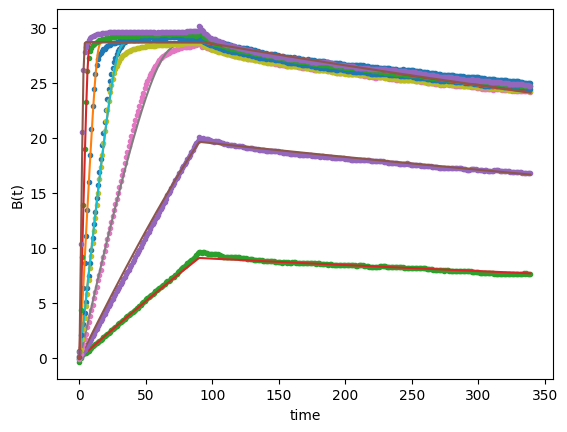

In [21]:
#infer on relative
eps=10.
param0=[1.5,30,0.5,0.1,0.1,1.,0.01] #alp,RUmax,kt,k1,km1,k2,km2
pfit=least_squares(fitfullrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta,eps],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1,k2,km2):",pfit.x)

solu=((pfit.fun).reshape(Ntime,Nconc))*(Data+eps)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

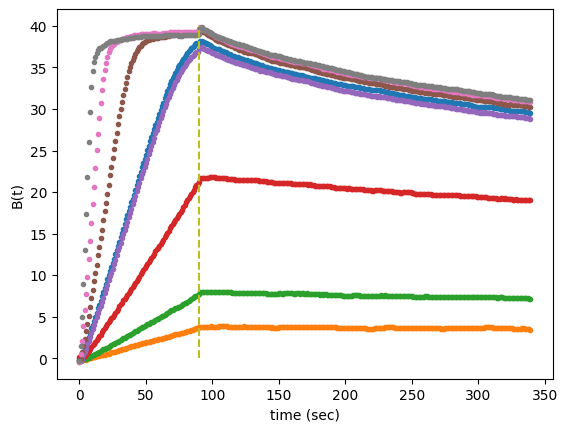

In [22]:
#load biacore data for LiCre and extract data
# RU_DNA=11 RU so RU_max ~ 40 and alp~2.2
dts=np.loadtxt('../../data/2023-06-01/biacore_licre_full_loxP.txt')
Nconc=len(np.unique(dts[:,1]))
Lconc=np.zeros(Nconc)
for c in range(1,Nconc+1):
    a=np.argwhere(dts[:,1]==c)
    Lconc[c-1]=dts[a[1],0] #in nM 
Ltime=dts[a,2]
ta=90 #in sec
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=4001 #index to end the fit
idt=10 #index of the step between two fitted points
Ltime=Ltime[np.arange(itimemin,itimemax,idt)]
Ntime=len(Ltime)
               
Data=np.zeros((Ntime,Nconc))
for c in range(Nconc):
    a=np.argwhere(dts[:,1]==(c+1))
    Data[:,c]=dts[a[np.arange(itimemin,itimemax,idt)],3].ravel()
    
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
plt.plot(ta+np.zeros(10),np.linspace(0,40,10),'--')
axes = plt.gca()
axes.set_xlabel('time (sec)')
axes.set_ylabel('B(t)')
plt.show()

scoring function: 0.003193455124508921
parameters (alp,RUmax,kt,k1,km1,k2,km2): [5.66384782e+00 3.75876427e+01 6.35188417e-02 1.47927295e-01
 6.06547387e+00 7.34158210e-01 5.10566988e-04]


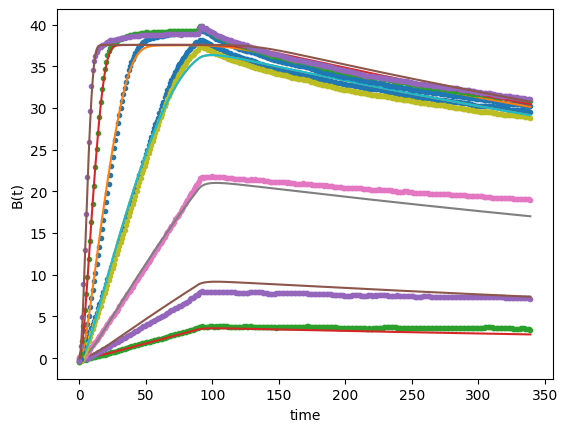

In [23]:
#infer on relative
eps=10.
param0=[2.2,40,0.5,0.1,0.1,1.,0.01] #alp,RUmax,kt,k1,km1,k2,km2
pfit=least_squares(fitfullrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconc,Lconc,Ntime,Ltime.ravel(),ta,eps],Data))
print("scoring function:",pfit.cost/Ntime)
print("parameters (alp,RUmax,kt,k1,km1,k2,km2):",pfit.x)

solu=((pfit.fun).reshape(Ntime,Nconc))*(Data+eps)+Data
for c in range(Nconc):
    plt.plot(Ltime,Data[:,c],'.')
    plt.plot(Ltime,solu[:,c],'-')
axes = plt.gca()
axes.set_xlabel('time')
axes.set_ylabel('B(t)')
plt.show()

## 3) Fitting model parameters using data for both half and full loxP site together
In the half loxP, the biacore signal $B^h(t)=\alpha P_1^h$, $B_{0/1/2}^h=\alpha P_{0/1/2}^h$ and $RU_{max}^h=\alpha P_{tot}^h$.
In the full loxP, $B^f(t)=\alpha (P_1^f+2 P_2^f)$, $B_{0/1/2}^f=\alpha P_{0/1/2}^f$ and $RU_{max}^f=2\alpha P_{tot}^f$. Then, the system is 
\begin{eqnarray}
d[C]^h/dt & = & k_t ([C]_0-[C]^h)-(k_1/\alpha) [C]^h(RU_{max}^h-B_1^h)+(k_{-1}/\alpha) B_1^h\\
dB_1^h/dt & = &   k_1 [C]^h(RU_{max}^h-B_1^h)-k_{-1} B^h \\
d[C]^f/dt & = & k_t ([C]_0-[C]^f)-2 (k_1/\alpha) [C]^f(RU_{max}^f/2-B_1^f-B_2^f)+(k_{-1}/\alpha) B_1^f-(k_2/\alpha) [C]^f B_1^f +2 (k_{-2}/\alpha) B_2^f\\
dB_1^f/dt & = &   2 k_1 [C]^f(RU_{max}^f/2-B_1^f-B_2^f)-k_{-1} B_1^f-k_2 [C]^f B_1^f+2 k_{-2} B_2^f\\
dB_2^f/dt & = & k_2 [C]^f B_1^f-2 k_{-2} B_2^f
\end{eqnarray}
where we have assumed that $k_t$ (mass transport parameter) and $\alpha$ are similar in both experiments.

In [2]:
# differential equation of the half and full loxP system
def halfb(y,t,param): #y=(C,B_1)
    alp,C0,ta,RUmax,kt,k1,km1=param
    dy=[0,0] #(dC/dt,dB_1/dt)
    B0=RUmax-y[1]
    if t<ta:
        dy[0]=kt*(C0-y[0])-k1/alp*y[0]*B0+km1/alp*y[1]
        dy[1]=k1*y[0]*B0-km1*y[1]
    else:
        dy[0]=kt*(-y[0])-k1/alp*y[0]*B0+km1/alp*y[1]
        dy[1]=k1*y[0]*B0-km1*y[1]
    return dy

def full1b(y,t,param): #y=(C,B1,B2)
    alp,C0,ta,RUmax,kt,k1,km1,k2,km2=param
    dy=[0,0,0] #dC/dt,dB_1/dt,dB_2/dt
    B0=RUmax/2-y[1]-y[2]
    if t<ta:
        dy[0]=kt*(C0-y[0])-2*(k1/alp)*y[0]*B0+(km1/alp)*y[1]-(k2/alp)*y[0]*y[1]+2*(km2/alp)*y[2]
        dy[1]= 2*k1*y[0]*B0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    else:
        dy[0]=kt*(-y[0])-2*k1/alp*y[0]*B0+km1/alp*y[1]-k2/alp*y[0]*y[1]+2*km2/alp*y[2]
        dy[1]= 2*k1*y[0]*B0-km1*y[1]-k2*y[0]*y[1]+2*km2*y[2]  
        dy[2]= k2*y[0]*y[1]-2*km2*y[2] 
    return dy

In [3]:
#infer based on relative
def fitallrel(param,xdatah,xdataf,ydatah,ydataf):
    Nconch,Lconch,Ntimeh,Ltimeh,tah,epsh=xdatah
    Nconcf,Lconcf,Ntimef,Ltimef,taf,epsf=xdataf
    alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2=param
    yh=np.zeros((Ntimeh,Nconch))
    for c in range(Nconch):
        yh[:,c]=odeint(halfb,[0,0],Ltimeh,args=([alp,Lconch[c],tah,RUmaxh,kt,k1,km1],))[:,1]  
    yf=np.zeros((Ntimef,Nconcf))
    for c in range(Nconcf):
        s=odeint(full1b,[0,0,0],Ltimef,args=([alp,Lconcf[c],taf,RUmaxf,kt,k1,km1,k2,km2],))
        yf[:,c]=s[:,1]+2*s[:,2]
    return np.concatenate(((yh-ydatah)/(ydatah+epsh),(yf-ydataf)/(ydataf+epsf)),axis=1).flatten()

In [4]:
#load biacore data for Cre and extract data
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=4001 #index to end the fit
idt=10 #index of the step between two fitted points

tah=90 #in sec
dtsh=np.loadtxt('../../data/2023-06-01/biacore_cre_half_loxP.txt')
Nconch=len(np.unique(dtsh[:,1]))
Lconch=np.zeros(Nconch)
for c in range(1,Nconch+1):
    a=np.argwhere(dtsh[:,1]==c)
    Lconch[c-1]=dtsh[a[1],0] #in nM 
Ltimeh=dtsh[a,2]
Ltimeh=Ltimeh[np.arange(itimemin,itimemax,idt)]
Ntimeh=len(Ltimeh)

taf=90 #in sec
dtsf=np.loadtxt('../../data/2023-06-01/biacore_cre_full_loxP.txt')
Nconcf=len(np.unique(dtsf[:,1]))
Lconcf=np.zeros(Nconcf)
for c in range(1,Nconcf+1):
    a=np.argwhere(dtsf[:,1]==c)
    Lconcf[c-1]=dtsf[a[1],0] #in nM 
Ltimef=dtsf[a,2]
Ltimef=Ltimef[np.arange(itimemin,itimemax,idt)]
Ntimef=len(Ltimef)
               
Datah=np.zeros((Ntimeh,Nconch))
for c in range(Nconch):
    a=np.argwhere(dtsh[:,1]==(c+1))
    Datah[:,c]=dtsh[a[np.arange(itimemin,itimemax,idt)],3].ravel()
Dataf=np.zeros((Ntimef,Nconcf))
for c in range(Nconcf):
    a=np.argwhere(dtsf[:,1]==(c+1))
    Dataf[:,c]=dtsf[a[np.arange(itimemin,itimemax,idt)],3].ravel()

In [5]:
#infer on relative
# RUmaxh = 0.033*32*38*1 ~ 40
# RUmaxf = 0.033*11*38*2 ~ 27
# alp ~ 1.5
eps=10.
param0=[1.5,40,27,0.5,0.1,0.1,1.,0.01] #alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2
pfit=least_squares(fitallrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconch,Lconch,Ntimeh,Ltimeh.ravel(),tah,eps],[Nconcf,Lconcf,Ntimef,Ltimef.ravel(),taf,eps],Datah,Dataf))
print("scoring function:",pfit.cost/(Ntimeh*Nconch+Ntimef*Nconcf))
print("parameters (alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2):",pfit.x)

scoring function: 0.0010910815648661235
parameters (alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2): [8.67245613e-01 3.82189834e+01 2.88032057e+01 5.10980015e-01
 9.61561272e-01 1.10620692e+00 4.98052140e-01 4.51844916e-04]


[Text(0.5, 0, 'time(sec)'), Text(0, 0.5, 'Bfull(t)')]

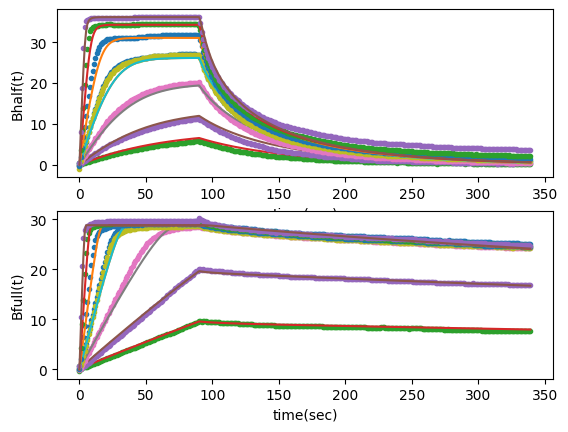

In [6]:
Data=np.concatenate((Datah,Dataf),axis=1)
fig, axs = plt.subplots(2)
solu=((pfit.fun).reshape(Ntimeh,Nconch+Nconcf))*(Data+eps)+Data
for c in range(Nconch):
    axs[0].plot(Ltimeh,Datah[:,c],'.')
    axs[0].plot(Ltimeh,solu[:,c],'-')
for c in range(Nconcf):
    axs[1].plot(Ltimef,Dataf[:,c],'.')
    axs[1].plot(Ltimef,solu[:,Nconch+c],'-')
axs.flat[0].set(xlabel='time(sec)', ylabel='Bhalf(t)')
axs.flat[1].set(xlabel='time(sec)', ylabel='Bfull(t)')

In [7]:
#We save this example of fit to build a figure in R and Inkscape
np.savetxt("cre-fit-example-data.txt",Data)
np.savetxt("cre-fit-example-solu.txt",solu)
np.savetxt("cre-fit-example-time.txt",Ltimef)

In [8]:
#load biacore data for LiCre and extract data
itimemin=601 #index to start the fit (corresponding to t=0)
itimemax=4001 #index to end the fit
idt=10 #index of the step between two fitted points

tah=90 #in sec
dtsh=np.loadtxt('../../data/2023-06-01/biacore_licre_half_loxP.txt')
Nconch=len(np.unique(dtsh[:,1]))
Lconch=np.zeros(Nconch)
for c in range(1,Nconch+1):
    a=np.argwhere(dtsh[:,1]==c)
    Lconch[c-1]=dtsh[a[1],0] #in nM 
Ltimeh=dtsh[a,2]
Ltimeh=Ltimeh[np.arange(itimemin,itimemax,idt)]
Ntimeh=len(Ltimeh)

taf=90 #in sec
dtsf=np.loadtxt('../../data/2023-06-01/biacore_licre_full_loxP.txt')
Nconcf=len(np.unique(dtsf[:,1]))
Lconcf=np.zeros(Nconcf)
for c in range(1,Nconcf+1):
    a=np.argwhere(dtsf[:,1]==c)
    Lconcf[c-1]=dtsf[a[1],0] #in nM 
Ltimef=dtsf[a,2]
Ltimef=Ltimef[np.arange(itimemin,itimemax,idt)]
Ntimef=len(Ltimef)
               
Datah=np.zeros((Ntimeh,Nconch))
for c in range(Nconch):
    a=np.argwhere(dtsh[:,1]==(c+1))
    Datah[:,c]=dtsh[a[np.arange(itimemin,itimemax,idt)],3].ravel()
Dataf=np.zeros((Ntimef,Nconcf))
for c in range(Nconcf):
    a=np.argwhere(dtsf[:,1]==(c+1))
    Dataf[:,c]=dtsf[a[np.arange(itimemin,itimemax,idt)],3].ravel()

In [9]:
#infer on relative
# RUmaxh = 0.033*32*55*1 ~ 58
# RUmaxf = 0.033*11*55*2 ~ 40
# alp ~ 2.2
eps=10.
param0=[2.2,58,40,0.5,0.1,0.1,1.,0.01] #alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2
pfit=least_squares(fitallrel,param0,jac='3-point',method='trf',bounds=(0,np.inf),args=([Nconch,Lconch,Ntimeh,Ltimeh.ravel(),tah,eps],[Nconcf,Lconcf,Ntimef,Ltimef.ravel(),taf,eps],Datah,Dataf))
print("scoring function:",pfit.cost/(Ntimeh*Nconch+Ntimef*Nconcf))
print("parameters (alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2):",pfit.x)

scoring function: 0.0019257849615610559
parameters (alp,RUmaxh,RUmaxf,kt,k1,km1,k2,km2): [1.70690437e+00 5.32186091e+01 3.81334400e+01 9.86276253e-02
 9.80225588e-01 4.81088033e-01 4.65493870e+00 2.86440057e-02]


[Text(0.5, 0, 'time(sec)'), Text(0, 0.5, 'Bfull(t)')]

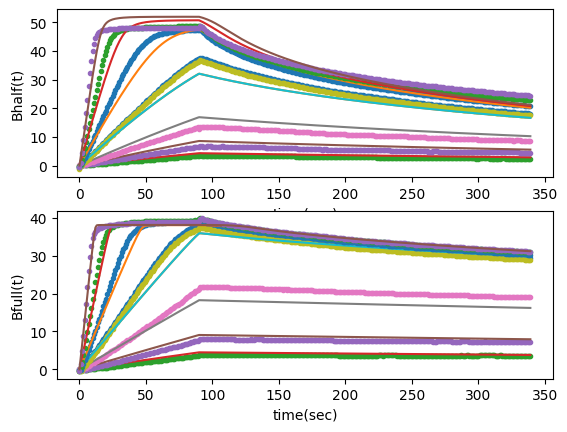

In [10]:
Data=np.concatenate((Datah,Dataf),axis=1)
fig, axs = plt.subplots(2)
solu=((pfit.fun).reshape(Ntimeh,Nconch+Nconcf))*(Data+eps)+Data
for c in range(Nconch):
    axs[0].plot(Ltimeh,Datah[:,c],'.')
    axs[0].plot(Ltimeh,solu[:,c],'-')
for c in range(Nconcf):
    axs[1].plot(Ltimef,Dataf[:,c],'.')
    axs[1].plot(Ltimef,solu[:,Nconch+c],'-')
axs.flat[0].set(xlabel='time(sec)', ylabel='Bhalf(t)')
axs.flat[1].set(xlabel='time(sec)', ylabel='Bfull(t)')

In [11]:
#We save this example of fit to build a figure in R and Inkscape
np.savetxt("licre-fit-example-data.txt",Data)
np.savetxt("licre-fit-example-solu.txt",solu)
np.savetxt("licre-fit-example-time.txt",Ltimef)